In [1]:
# Core
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline

# Astronomy
from astropy.time import Time
from astropy.units import deg

# Utility
import os
from datetime import date
import time
from tqdm.auto import tqdm

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image

# Libraries for getting Alerce data out of ZTF2 database
import json
import psycopg2
from alerce.api import AlerceAPI

# MSE imports
from utils import range_inc
from astro_utils import date_to_mjd, mjd_to_date
from asteroid_integrate import load_data as load_orbital_elts
from ztf_data import load_ztf_det_all, load_ztf_nearest_ast, ztf_nearest_ast
from ztf_data_viz import ztf_obs_by_month, cdf_nearest_dist, deg2dist, dist2deg, plot_cdf_uncond, plot_cdf_cond, plot_dist
from asteroid_dataframe import spline_ast_vec_dir

In [2]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

### Load Detections from Alerce ZTF2 Database

In [3]:
ztf, mjd_unq = load_ztf_det_all()

In [4]:
# Review DataFrame
ztf

,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob
0,b'ZTF18acebhfp',676397301515010013,14490,58430.397303,41.357345,58.879488,0.387942,0.653853,0.649598,18.946699,0.865682
1,b'ZTF18abodmwk',596403415715010014,5831,58350.403414,30.969721,65.305308,0.358224,0.558644,0.748059,19.010401,0.855504
2,b'ZTF18abodmwk',626428345715010011,10614,58380.428345,30.969705,65.305294,0.358224,0.558644,0.748059,18.935900,0.855504
3,b'ZTF18abodmwk',630507595715015045,11250,58384.507593,30.969940,65.305305,0.358223,0.558645,0.748059,19.260401,0.855504
4,b'ZTF18abodmwk',618384965715010022,9040,58372.384965,30.969643,65.305179,0.358226,0.558644,0.748058,19.220200,0.855504
...,...,...,...,...,...,...,...,...,...,...,...
5459014,b'ZTF20aareruw',1151532523515015015,97109,58905.532523,253.007910,55.485537,-0.165587,-0.169403,0.971537,19.192400,0.608023
5459015,b'ZTF20aarerwx',1151533002615015009,97110,58905.533009,232.886408,53.509617,-0.358833,-0.115301,0.926253,19.687099,0.559474
5459016,b'ZTF20aarerww',1151533002115010003,97110,58905.533009,236.167899,54.618457,-0.322375,-0.116973,0.939357,19.957001,0.392662
5459017,b'ZTF20aarervr',1151526063515015015,97098,58905.526065,286.235286,33.876902,0.232120,-0.509626,0.828494,19.049299,0.517241


In [5]:
# Review data types
ztf.dtypes

ObjectID            |S12
CandidateID        int64
TimeStampID        int32
mjd              float64
ra               float64
dec              float64
ux               float64
uy               float64
uz               float64
mag_app          float64
asteroid_prob    float64
dtype: object

In [6]:
# Sanity check: we should be able to recover the mjd of an observation by indexing into mjd_unq
assert np.all(mjd_unq[ztf.TimeStampID] == ztf.mjd)

### Summarize Observations by Month

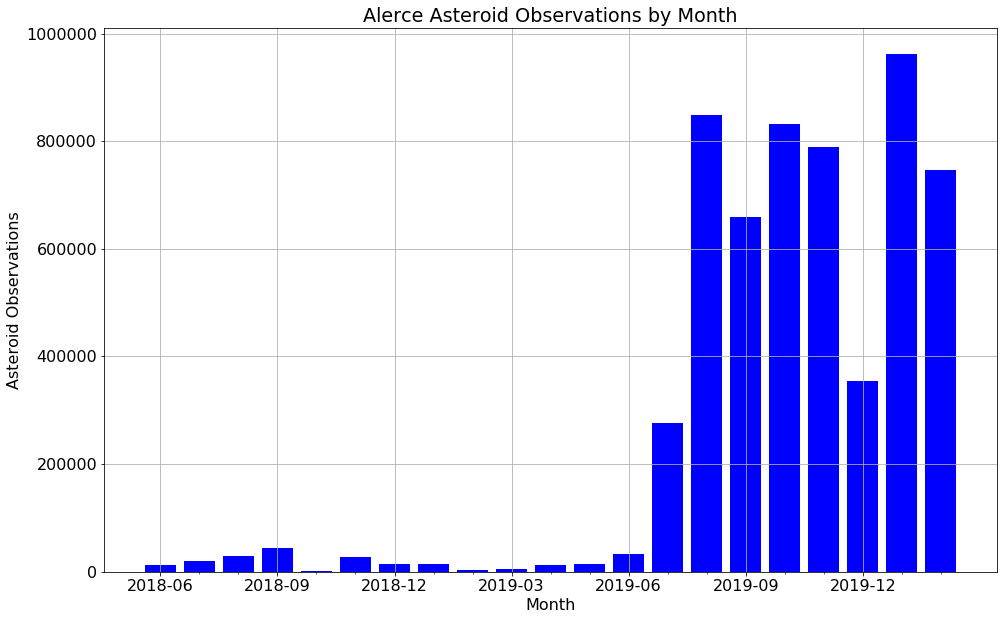

In [7]:
# Generate bar chart
# ztf_obs_by_month(ztf)

# Display the bar chart
Image(filename='../figs/ztf/ztf_ast_per_month.png')

### Extract key Data from ZTF Frame

In [8]:
# Extract mjd, ra, and dec of the ZTF observations as arrays of astropy angles
# mjd_ztf = ztf.mjd.values
# ra_ztf = ztf.ra.values
# dec_ztf = ztf.dec.values

In [9]:
# Extract directions of the ZTF observations as an Nx3 array
# u_ztf = ztf[['ux', 'uy', 'uz']].values

### Load MSE Calculated Asteroid Directions for Comparison to ZTF

In [10]:
# Date range in ZTF data
mjd_min = np.min(mjd_unq)
mjd_max = np.max(mjd_unq)
dt_min = mjd_to_date(mjd_min)
dt_max = mjd_to_date(mjd_max)
print(f'ZTF mjd range : {mjd_min:9.3f} to {mjd_max:9.3f}')
print(f'ZTF date range: {dt_min} to {dt_max}')

ZTF mjd range : 58270.170 to 58905.533
ZTF date range: 2018-06-01 to 2020-02-26


In [11]:
# Range of asteroids to compare to ZTF
n0: int = 0
n1: int = 16000

# Observatory site
# site_name = 'palomar'

In [12]:
# Build splined positions and observations against unique observation times
# ast_pos, earth_pos, ast_dir = spline_ast_vec_dir(n0=n0, n1=n1, mjd=mjd_unq, site_name=site_name)

In [13]:
# Get asteroid numbers in selected range
orb_elt = load_orbital_elts()
ast_mask = (n0 <= orb_elt.Num) & (orb_elt.Num < n1)
ast_nums = orb_elt.Num[ast_mask].values.astype(np.int32)

In [14]:
# Find nearest asteroid to ZTF observations
thresh_deg = 180.0
# ztf = ztf_nearest_ast(ztf=ztf, n0=n0, n1=n1, thresh_deg=thresh_deg, regen=False)
ztf = load_ztf_nearest_ast(n0=n0, n1=n1)

In [15]:
ztf

,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz
0,b'ZTF18acebhfp',676397301515010013,14490,58430.397303,41.357345,58.879488,0.387942,0.653853,0.649598,18.946699,0.865682,8345,0.094653,45.676425,54.004879,0.410643,0.707589,0.575057
1,b'ZTF18abodmwk',596403415715010014,5831,58350.403414,30.969721,65.305308,0.358224,0.558644,0.748059,19.010401,0.855504,945,0.240244,38.510983,52.051389,0.481195,0.664986,0.571179
2,b'ZTF18abodmwk',626428345715010011,10614,58380.428345,30.969705,65.305294,0.358224,0.558644,0.748059,18.935900,0.855504,945,0.118622,41.742629,60.567169,0.366657,0.646609,0.668925
3,b'ZTF18abodmwk',630507595715015045,11250,58384.507593,30.969940,65.305305,0.358223,0.558645,0.748059,19.260401,0.855504,945,0.104112,41.491683,61.609575,0.356157,0.638951,0.681831
4,b'ZTF18abodmwk',618384965715010022,9040,58372.384965,30.969643,65.305179,0.358226,0.558644,0.748058,19.220200,0.855504,945,0.148735,41.659926,58.396349,0.391512,0.658374,0.642854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5459014,b'ZTF20aareruw',1151532523515015015,97109,58905.532523,253.007910,55.485537,-0.165587,-0.169403,0.971537,19.192400,0.608023,5765,0.539970,195.310840,56.495384,-0.532412,0.197951,0.823014
5459015,b'ZTF20aarerwx',1151533002615015009,97110,58905.533009,232.886408,53.509617,-0.358833,-0.115301,0.926253,19.687099,0.559474,5765,0.372713,195.310765,56.495466,-0.532411,0.197952,0.823015
5459016,b'ZTF20aarerww',1151533002115010003,97110,58905.533009,236.167899,54.618457,-0.322375,-0.116973,0.939357,19.957001,0.392662,5765,0.396016,195.310765,56.495466,-0.532411,0.197952,0.823015
5459017,b'ZTF20aarervr',1151526063515015015,97098,58905.526065,286.235286,33.876902,0.232120,-0.509626,0.828494,19.049299,0.517241,3752,0.147760,278.003121,29.120911,0.121628,-0.600121,0.790608


### Analyze Distribution of Nearest Asteroid Distance

In [16]:
# Convert threshold from degrees to cartesian distance
# thresh_rad = np.deg2rad(thresh_deg)
# thresh_dist = np.sin(thresh_rad/2.0)*2.0
thresh_close_sec = 10.0
thresh_close_deg = thresh_close_sec / 3600
thresh_dist = deg2dist(thresh_close_deg)

# Count number of asteroids matched against
ast_count = ast_nums.size
# Number of rows in data
N_obs = ztf.shape[0]

# Count frequency of matches
is_close = ztf.nearest_ast_dist < thresh_dist
match_frac_obs = np.mean(is_close)
match_frac_ran = cdf_nearest_dist(dist=thresh_dist, n=ast_count)
match_count_obs = np.sum(is_close)
match_count_ran = N_obs * match_frac_ran
match_ratio = match_frac_obs / match_frac_ran

print(f'Testing {ast_count} asteroids at threshold = {thresh_close_sec} arc sec.')
print(f'Observed match count = {match_count_obs:6d}')
print(f'Random   match count = {match_count_ran:6.0f}')
print(f'Observed match fraction = {match_frac_obs:8.6f}')
print(f'Random   match fraction = {match_frac_ran:8.6f}')
print(f'Ratio =  {match_ratio:8.6f}')

Testing 15993 asteroids at threshold = 10.0 arc sec.
Observed match count = 507549
Random   match count =     54
Observed match fraction = 0.089076
Random   match fraction = 0.000009
Ratio =  9478.526045


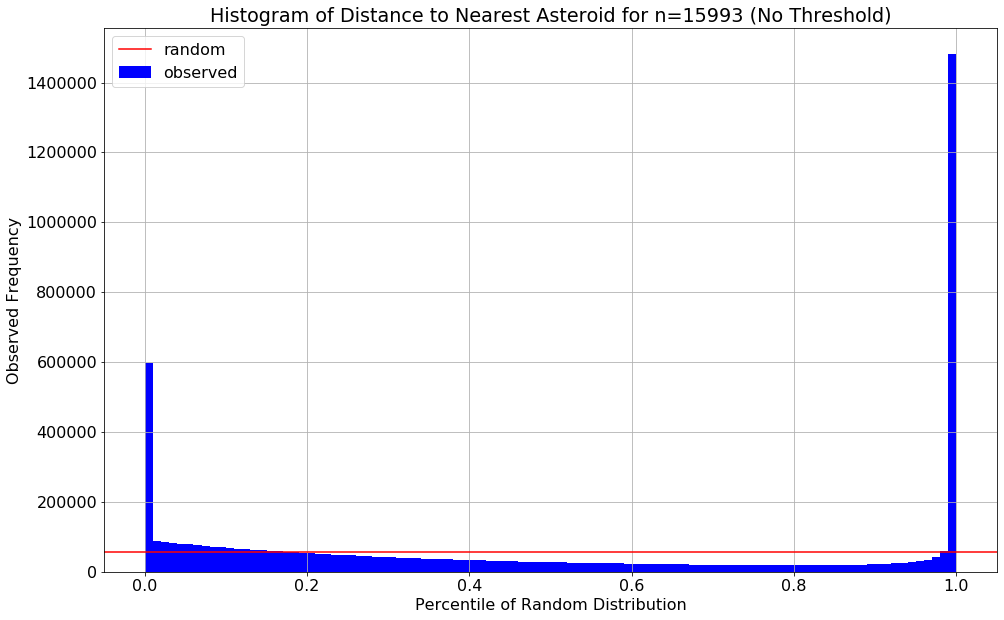

In [17]:
# Plot the unconditional distribution
fig, ax = plot_cdf_uncond(ztf=ztf, n=ast_count, bins=100)

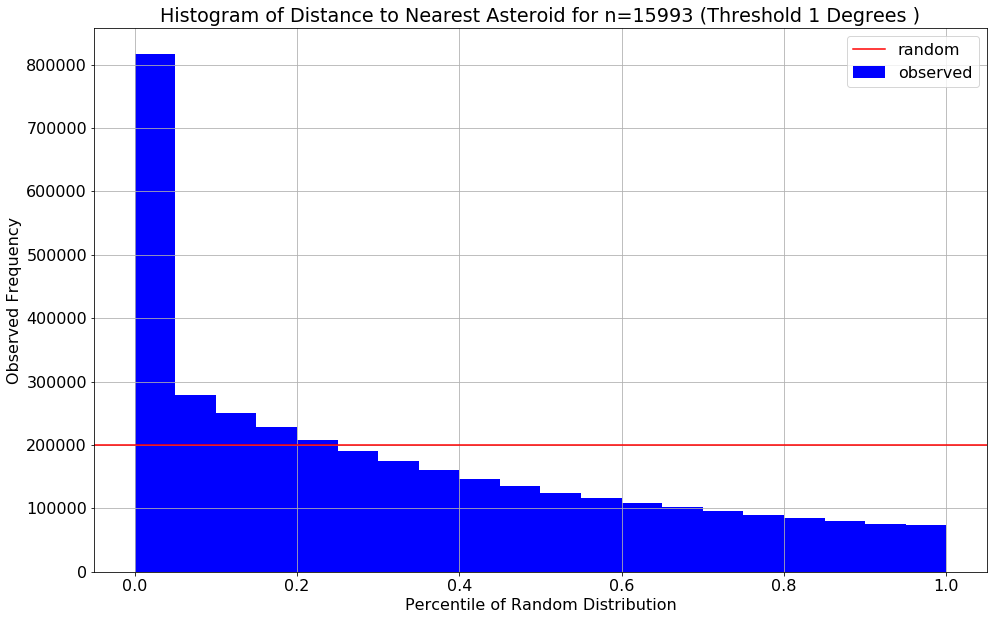

In [18]:
# Plot the conditional distribution at a threshold of 1.0 degrees
fig, ax = plot_cdf_cond(ztf=ztf, n=ast_count, thresh_deg=1.0, bins=20)

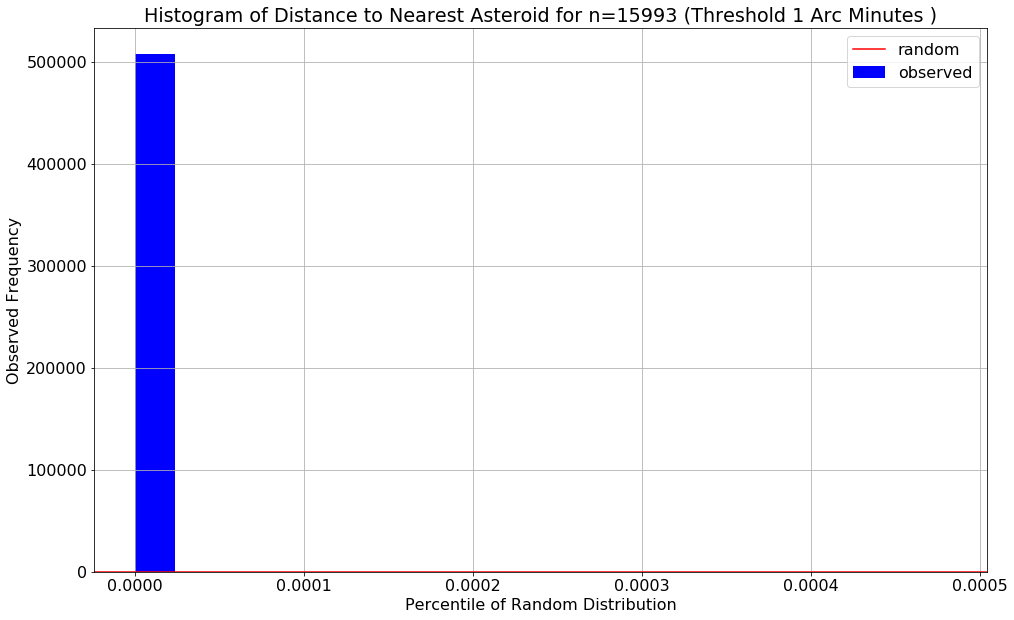

In [19]:
# Plot the conditional distribution at a threshold of 1 arc minute
thresh_one_min = 1.0 / 60
fig, ax = plot_cdf_cond(ztf=ztf, n=ast_count, thresh_deg=thresh_one_min, bins=20)

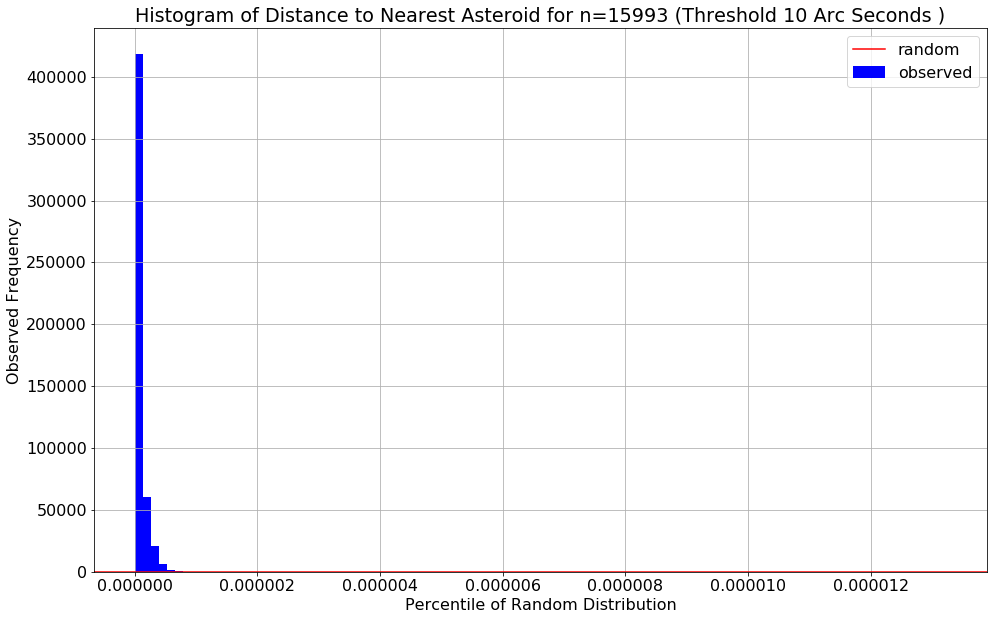

In [20]:
# Plot the conditional distribution at a threshold of 10 arc seconds
thresh_ten_sec = 10.0 / 3600
fig, ax = plot_cdf_cond(ztf=ztf, n=ast_count, thresh_deg=thresh_ten_sec, bins=100)

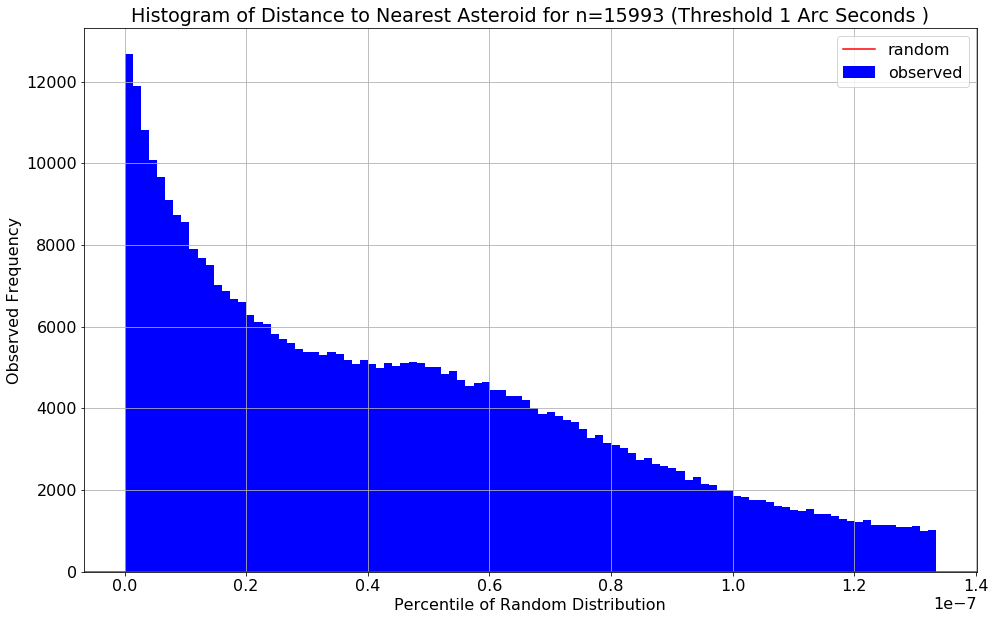

In [21]:
# Plot the conditional distribution at a threshold of 10 arc seconds
thresh_one_sec = 1.0 / 3600
fig, ax = plot_cdf_cond(ztf=ztf, n=ast_count, thresh_deg=thresh_one_sec, bins=100)

### Explore Observations that are Close to One Asteroid

In [22]:
thresh_sec_close = 10
thresh_deg_close = thresh_sec_close / 3600
thresh_dist_close = deg2dist(thresh_deg_close)
print(f'Threshold to be close:')
print(f'{thresh_sec_close} arc seconds')
print(f'{thresh_dist_close:6.2e} cartesian distance')

is_close = ztf.nearest_ast_dist < thresh_dist_close

Threshold to be close:
10 arc seconds
4.85e-05 cartesian distance


In [23]:
ztfc = ztf[is_close].copy()
ztfc

,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz
1117,b'ZTF18acanrxo',643466621015015121,12518,58397.466620,89.743119,22.660836,0.004137,0.999899,-0.013582,19.631100,1.0,11203,0.000003,89.742947,22.660806,0.004140,0.999899,-0.013583
1218,b'ZTF18abtgmhj',611406333315015026,7712,58365.406331,25.092738,12.952392,0.882580,0.468349,0.041247,18.682800,1.0,7970,0.000001,25.092811,12.952366,0.882580,0.468350,0.041246
1722,b'ZTF18acpvbwp',687443910415015020,16756,58441.443912,60.674897,16.570104,0.469425,0.880133,-0.070746,16.642599,1.0,4389,0.000004,60.675112,16.570126,0.469422,0.880135,-0.070747
2834,b'ZTF18abuxlcj',617426480415015007,8871,58371.426481,24.512951,16.746337,0.871280,0.479132,0.106321,15.805700,1.0,3900,0.000002,24.513038,16.746292,0.871279,0.479133,0.106319
6065,b'ZTF18adatafz',726300331215015032,20351,58480.300336,56.817883,16.398282,0.525039,0.848935,-0.060355,17.142200,1.0,7210,0.000002,56.817986,16.398277,0.525038,0.848936,-0.060355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5458886,b'ZTF20aarepii',1151522393415015017,97090,58905.522396,236.892710,-2.341055,-0.545753,-0.784135,0.295442,15.089800,1.0,727,0.000002,236.892569,-2.341034,-0.545755,-0.784134,0.295442
5458889,b'ZTF20aareowa',1151522390315015003,97090,58905.522396,237.654792,-5.909325,-0.532176,-0.811960,0.239813,15.717300,1.0,625,0.000002,237.654657,-5.909328,-0.532178,-0.811958,0.239813
5458890,b'ZTF20aareowm',1151521944715015006,97089,58905.521944,236.239354,-9.304550,-0.548413,-0.817041,0.178007,15.695800,1.0,464,0.000002,236.239228,-9.304526,-0.548415,-0.817040,0.178007
5458895,b'ZTF20aareowf',1151521946215015005,97089,58905.521944,234.674482,-7.771349,-0.572910,-0.795468,0.197496,16.917900,1.0,2879,0.000004,234.674242,-7.771368,-0.572914,-0.795466,0.197494


In [25]:
# Group results by asteroid number
close_by_ast = ztfc.groupby(ztfc.nearest_ast_num)
close_by_ast_count = close_by_ast.size()
close_ast_num = close_by_ast_count.index.values
close_ast_count = close_by_ast_count.values

In [31]:
np.sum(close_ast_count >= 20)

7793

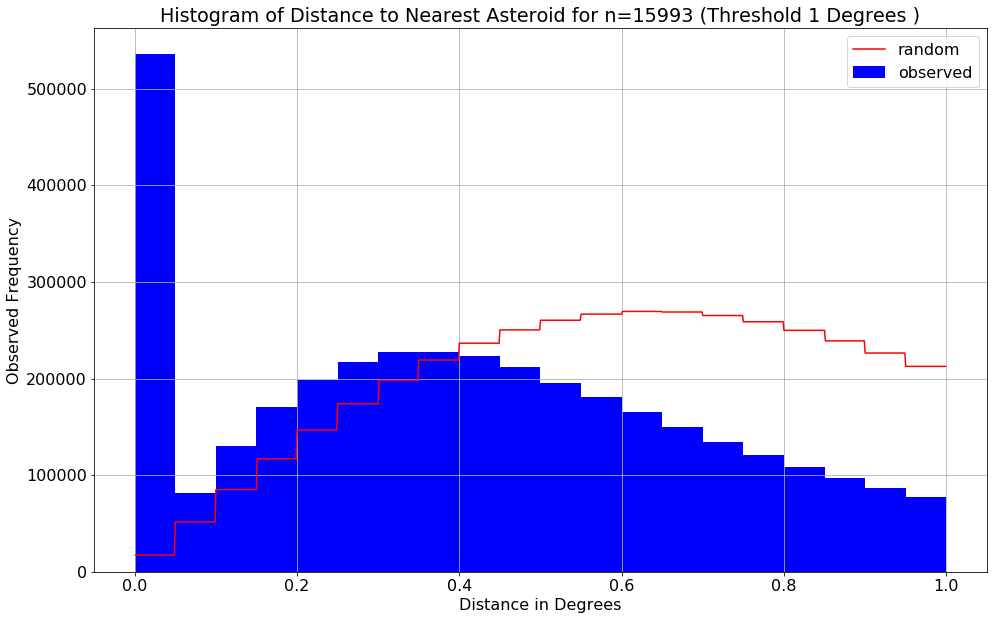

In [26]:
fig, ax = plot_dist(ztf, n=ast_count, thresh_deg=1.0)

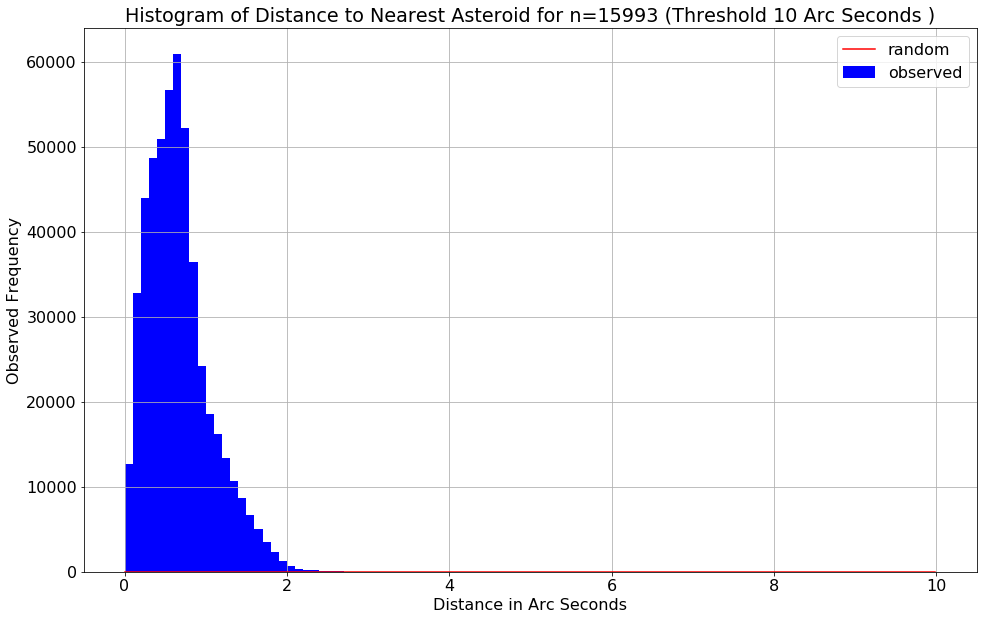

In [30]:
fig, ax = plot_dist(ztf, n=ast_count, thresh_deg=thresh_ten_sec, bins=100)